## Machine Learning


#### Μέλη Ομάδας:
- Ευάγγελος Λευτάκης : 3200093
- Ρέα Σκλήκα : 3210181
- Σοφία-Ζωή Σωτηρίου : 3210192

### Dependencies

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

### 1st Part

First We Prepare the train, dev and test data and create a binary representation of it.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

(x_train_imdb, y_train), (x_test_imdb, y_test) = tf.keras.datasets.imdb.load_data()


# x_train_imdb, y_train_imdb = temp_x_train_imdb[:split_index], y_train[:split_index]
# x_dev_imdb, y_dev_imdb = temp_x_train_imdb[split_index:], y_train[split_index:]

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])

binary_vectorizer = CountVectorizer(binary=True, min_df=100)
x_train = binary_vectorizer.fit_transform(x_train_imdb)
x_test = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)
x_train = x_train.astype(int)
x_test = x_test.astype(int)
# print(x_train.shape)



Vocabulary size: 3834


#### Logistic Regression:


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.sparse import issparse
class LogisticRegression():
   

    def __init__(self,epochs=20,learning_rate=0.001,threshold=0.5, regularization_factor=1):
        self.epochs=epochs;
        self.learning_rate=learning_rate
        self.weights = np.array([])
        self.threshold=threshold
        self.regularization_factor = regularization_factor
        
    
    def set_threshold(self,value):
        self.threshold = value
    def sigmoid(self , t):
        return 1/(1+np.exp(-t))


    def fit(self,x_train_input,y_train_input):
        ''' '''
        feature_vector_length = x_train_input.shape[1]
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        x_dev = x_dev.toarray()

        x_train = x_train.toarray()
        ones_column = np.ones(x_train.shape[0])
        x_train = np.insert(x_train, 0, ones_column, axis=1)
        self.weights = self.initialize_weights(feature_vector_length)
        
        for epoch in range(self.epochs):
            for i in range(x_train.shape[0]):
                x_i = x_train[i-1]
                y_i = y_train[i-1]

                self.update_weights(x_i,y_i)
        y_dev_predicted = self.predict(x_dev)
        return self.evaluate(y_dev_predicted, y_dev)       

        print("Done!!")


        
    
    def predict(self, x_test):
        
        features_length = x_test.shape[1]
        if issparse(x_test):
            x_test = x_test.toarray()
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []


        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            predicted_class = 1 if probability_positive >= self.threshold else 0
            y_test_predicted.append(predicted_class)
        return np.array(y_test_predicted)



    @staticmethod
    def initialize_weights(size):
        '''We Initialize the weights with random values with a mean of 0 and a standard deviation of 0.01
          This is a common practice to prevent the weights from being too large at the begining '''
        return np.random.randn(size+1) * 0.01

    def update_weights(self,x_test,y_test):
        predicted_prob = self.sigmoid(np.dot(self.weights,x_test))
        gradient = ((y_test - predicted_prob) * x_test)
        self.weights += self.learning_rate * gradient 
    
    def evaluate(self, y_true, y_predicted):
        accuracy = accuracy_score(y_true, y_predicted)
        print("Accuracy:", accuracy)

        precision = precision_score(y_true, y_predicted)
        print("Precision:", precision)

        # Compute recall
        recall = recall_score(y_true, y_predicted)
        print("Recall:", recall)

        # Compute F1 score
        f1 = f1_score(y_true, y_predicted)
        print("F1 Score:", f1)
        print("Threshold: "+str(self.threshold))
        return np.array([precision,recall])
    

    def generate_pr_curve(self, x_train_input,y_train_input,size=20):
        currentThreshold = 0
        percisions=[]
        recalls=[]
        for i in range(size):
            currentThreshold += 1./size
            if (currentThreshold>0.3 and currentThreshold<0.75):
                self.set_threshold(currentThreshold)
                fit_pr = self.fit(x_train_input , y_train_input)
                percisions.append(fit_pr[0])
                recalls.append(fit_pr[1])
        print(percisions)
        plt.plot(recalls,percisions ,label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Diagram')
        plt.legend()
        plt.show()


#### Results
Here we try out the Logistic Regression learning algorithm

Accuracy: 0.8702
Precision: 0.9185905224787363
Recall: 0.8350515463917526
F1 Score: 0.8748312439729989
Threshold: 0.35
Accuracy: 0.875
Precision: 0.9048197650870798
Recall: 0.8513719512195121
F1 Score: 0.8772825446691537
Threshold: 0.39999999999999997
Accuracy: 0.8778
Precision: 0.8922640745240988
Recall: 0.8645996860282574
F1 Score: 0.8782140721546741
Threshold: 0.44999999999999996
Accuracy: 0.8774
Precision: 0.8813284730660186
Recall: 0.8717948717948718
F1 Score: 0.8765357502517622
Threshold: 0.49999999999999994
Accuracy: 0.876
Precision: 0.8655326042932361
Recall: 0.8812371134020619
F1 Score: 0.8733142623620761
Threshold: 0.5499999999999999
Accuracy: 0.871
Precision: 0.8448764682057514
Recall: 0.8884156729131175
F1 Score: 0.8660992318870666
Threshold: 0.6
Accuracy: 0.8692
Precision: 0.8258404212231673
Recall: 0.9010163499779055
F1 Score: 0.8617920540997465
Threshold: 0.65
Accuracy: 0.8636
Precision: 0.8027541514783313
Recall: 0.9104271933853928
F1 Score: 0.8532070598364184
Threshold

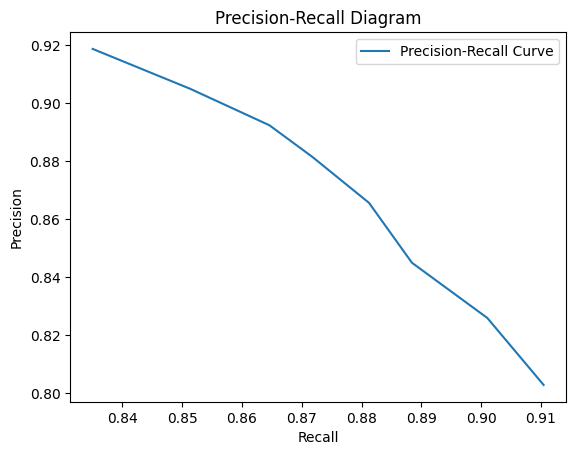

In [41]:
LogReg = LogisticRegression(100,threshold=0.5, regularization_factor=0.01)
LogReg.fit(x_train,y_train)
y_predicted = LogReg.predict(x_test)
# fit(x_train,y_train)
 
# y_predicted = LogReg.predict(x_test)

LogReg.evaluate(y_test,y_predicted)